# Transformer BERTForQuestionAnswering Custom Training Script

## Important comments:

The fine-tuning of the BERT model takes a while to perform. Be prepared to wait and for the session to possibly timeout. 

Make sure to upload/import the 4 dataset .csv files into your Google Collaboratory environment. This can be done in the following steps:
1. Click the 'Files' icon at the very left of this window
2. Within this window, click the 'Upload to session storage' icon.
3. Select the 4 .csv (2 training and 2 test) files stored either locally on your computer or on your Google Drive.
4. Import the files.

### Install the Huggingface Transformers Python package

In [ ]:
!pip install transformers

### Import Packages 

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import transformers
transformers.logging.set_verbosity_error()
# from transformers import BertTokenizer, AutoTokenizer, BertForQuestionAnswering, BertTokenizerFast, BertConfig, DistilBertForQuestionAnswering, DistilBertTokenizerFast
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import BertTokenizer,AutoTokenizer,BertForQuestionAnswering
from torch.optim import AdamW
import random
import re
import spacy

### Import the Training Dataset and the training article dataset

In [ ]:
training_BERT_filename = "/content/squad_training_dataset_BERT.csv"
training_BERT_dataset_df = pd.read_csv(training_BERT_filename)

#remove the questions from the dataset that do not contain answers
training_BERT_dataset_df = training_BERT_dataset_df.dropna()
display(training_BERT_dataset_df)

,Unnamed: 0,topic,question,answer,answer_start,question_id,answer_context
0,0,Beyonce,When did Beyonce start becoming popular?,in the late 1990s,269.0,56be85543aeaaa14008c9063,Beyonce Giselle Knowles-Carter (/bi:'janseI/ b...
1,1,Beyonce,What areas did Beyonce compete in when she was...,singing and dancing,207.0,56be85543aeaaa14008c9065,Beyonce Giselle Knowles-Carter (/bi:'janseI/ b...
2,2,Beyonce,When did Beyonce leave Destiny's Child and bec...,2003,526.0,56be85543aeaaa14008c9066,Beyonce Giselle Knowles-Carter (/bi:'janseI/ b...
3,3,Beyonce,In what city and state did Beyonce grow up?,"Houston, Texas",166.0,56bf6b0f3aeaaa14008c9601,Beyonce Giselle Knowles-Carter (/bi:'janseI/ b...
4,4,Beyonce,In which decade did Beyonce become famous?,late 1990s,276.0,56bf6b0f3aeaaa14008c9602,Beyonce Giselle Knowles-Carter (/bi:'janseI/ b...
...,...,...,...,...,...,...,...
130046,130046,Kathmandu,In what US state did Kathmandu first establish...,Oregon,229.0,5735d259012e2f140011a09d,"Kathmandu Metropolitan City (KMC), in order to..."
130047,130047,Kathmandu,What was Yangon previously known as?,Rangoon,414.0,5735d259012e2f140011a09e,"Kathmandu Metropolitan City (KMC), in order to..."
130048,130048,Kathmandu,With what Belorussian city does Kathmandu have...,Minsk,476.0,5735d259012e2f140011a09f,"Kathmandu Metropolitan City (KMC), in order to..."
130049,130049,Kathmandu,In what year did Kathmandu create its initial ...,1975,199.0,5735d259012e2f140011a0a0,"Kathmandu Metropolitan City (KMC), in order to..."


#### We are going to have to condense the size of the training dataset so that we can actually run it and get a result within a reasonable amount of time

In [ ]:
#we will be using the BERT dataset only as previous testing has shown that punctuation is necessary
#take a subset from the training dataset
samples = 86800
training_data_df = training_BERT_dataset_df.sample(n = samples)
# training_data_df = training_BERT_dataset_df.iloc[0:samples]
display(training_data_df)

,Unnamed: 0,topic,question,answer,answer_start,question_id,answer_context
58128,58128,Department store,What were some of the original Australian depa...,Grace Bros. and Waltons,118.0,572657a0f1498d1400e8dc86,Although there were a number of department sto...
101661,101661,Muammar Gaddafi,What was the profession of Gaddafi's father?,goat herder,35.0,57316b37e6313a140071cf1a,The son of an impoverished Bedouin goat herder...
127033,127033,Genocide,"With Milosevic dead, who did the ICTY next cha...",Radovan Karadzic and Ratko Mladic,380.0,57340aae4776f41900661792,"Slobodan Milosevic, as the former President of..."
117141,117141,Sumer,What language was in use in the Neo-Sumerian E...,Akkadian,161.0,5730a771069b53140083220b,Native Sumerian rule re-emerged for about a ce...
76087,76087,Dissolution of the Soviet Union,Who arrived to protect the White House?,Muscovites,13.0,57283e793acd2414000df7ab,Thousands of Muscovites came out to defend the...
...,...,...,...,...,...,...,...
36107,36107,Gregorian calendar,By how much is the Julian calendar too long?,11 minutes,228.0,570b03a2ec8fbc190045b7d9,Lilius's proposals had two components. Firstly...
95282,95282,Appalachian Mountains,What mountains does that region include?,Catskill Mountains,211.0,57299f39af94a219006aa576,"In addition to the true folded mountains, know..."
65488,65488,Alloy,How is steel produced?,Adding a small amount of non-metallic carbon t...,400.0,57269e385951b619008f77eb,When the alloy cools and solidifies (crystalli...
18950,18950,Daylight saving time,"In Australia, were rural or urban areas genera...",rural,176.0,56e74ffe37bdd419002c3e54,"In 1992, after a three-year trial of daylight ..."


### Extract the questions, answer, paragraphs, and answer starts from the sample dataset

In [ ]:
train_questions = training_data_df['question'].to_list()
train_answers = training_data_df['answer'].to_list()
train_topics = training_data_df['topic'].to_list()
train_answers_start = training_data_df['answer_start'].to_list()
train_paragraphs = training_data_df['answer_context'].to_list()

### Find the end position of the correct answer for each question in training dataset

In [ ]:
def Get_Answer_EndPosition(answers,answers_start):
    #generate a dictionary of text, answer start, and answer end
    train_answers = []
    for i in range(len(answers)):
        #get the answer end of the dataset
        start = answers_start[i]
        curr_answer = str(answers[i])
        
        start = int(start)
        end = int(start + len(curr_answer))

        temp_dict = {'text':curr_answer,'answer_start':start,'answer_end':end}

        train_answers.append(temp_dict)
        
    return train_answers

train_answers = Get_Answer_EndPosition(train_answers,train_answers_start)
print(train_answers[0])

{'text': 'Grace Bros. and Waltons', 'answer_start': 118, 'answer_end': 141}


### Tokenize the paragraphs and the questions

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_paragraphs,train_questions,truncation=True,padding=True)

#define function that adds the start and end encodings
def Append_StartEnd_Positions(tokenizer,encodings, answers):
    #create lists that contain the token indices of answer start and end pairs
    start_indices = []
    end_indices = []
    
    for i in range(len(answers)):
        #create tokens for the start and end position words
        curr_start_encoding = encodings.char_to_token(i,answers[i]['answer_start'])
        curr_end_encoding = encodings.char_to_token(i,answers[i]['answer_end'])

        #append stuff
        start_indices.append(curr_start_encoding)
        end_indices.append(curr_end_encoding)

        #check to see if the last encoding was of type none
        if(start_indices[-1] is None):
            start_indices[-1] = tokenizer.model_max_length
        #now handle the end word since the start word was set to the token of the last word
        offset = 1
        while(end_indices[-1] is None):
            end_indices[-1] = encodings.char_to_token(i,answers[i]['answer_end']-offset)
            offset += 1

    #modify the encoding object
    encodings.update({'start':start_indices,'end':end_indices})

#call the function on the training dataset
Append_StartEnd_Positions(tokenizer,train_encodings,train_answers)

### Set-up GPU usage for PyTorch

In [ ]:
device = torch.device('Using GPU(s)' if torch.cuda.is_available() else 'Using CPU')
print(device)

cuda:0


### Initialize the dataset as a tensor

In [ ]:
#create a class to handle the conversion from tokens to PyTorch Tensors
#this will convert the tokenized encodings into encoding that PyTorch can handle
class Tensor_TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        
    def __getitem__(self, index):
#         for key, val in self.encodings.items():
#             return {key: torch.tensor(val[index])}
        return {key : torch.as_tensor(val[index]) for key, val in self.encodings.items()}
    
    def __len__(self):
        return len(self.encodings.input_ids)
    
#build tensor dataset for the training dataset
train_tensor_dataset = Tensor_TrainingDataset(train_encodings)

### Define the Model 

In [ ]:
BERT_model = BertForQuestionAnswering.from_pretrained("bert-base-uncased").to(device)

### Define Process for Model Training

In [ ]:
def Train_BERT(model,training_data,learning_rate,num_epochs,batch_size=10):
    #make training mode accessible
    model.train()

    #define the adam optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    #define a data loader object for handling our training data
    train_loader = DataLoader(training_data,batch_size=batch_size,shuffle=True)

    #define an list to store the losses
    losses = []
    
    #iterate over the number of epochs
    epochs = num_epochs
    for epoch in range(epochs):
        model.train()

        #setup the progess bar
        progress = tqdm(train_loader, leave=True)

        #iterate over the number of items in the loader object
        for batch in progress:
            #initialize the gradient calculations to zero (reset gradients)
            optimizer.zero_grad()

            #collect the tensor batches for training
            input_ids = batch['input_ids'].to(device)

            #collect the attention mask layer data
            attention_mask = batch['attention_mask'].to(device)

            #get the true start and end positions
            start_pos = batch['start'].to(device).to(device)
            end_pos = batch['end'].to(device).to(device)

            #conduct training on the model
            outputs = model(input_ids,attention_mask=attention_mask,start_positions=start_pos,end_positions=end_pos)

            #get the loss
            loss = outputs[0]

            #compute the gradients
            loss.backward()

            #update the gradient parameters in memory
            optimizer.step()
            
            #append the current loss to the losses list
            losses.append(loss.item())

            #update the progress bar
            progress.set_description(f'Epoch {epoch}')
            progress.set_postfix(loss=loss.item())
            
    return model, losses

### Run the training of the BERT model, then immediately save the model to avoid any issues with Google Colab session timeout.

Hack:

To avoid Google Colaboratory session timeout,
  
1. Open the Settings tab of Google Chrome
2. Navigate to 'More Tools' --> click 'Developer Tools'
3. A tab will now open with the Developer tools. At the top of the tools tab select 'Console'
4. In the Console command line, add the following code:

  function ClickConnect(){
      console.log("Working"); 
      document.querySelector("colab-toolbar-button").click()}
setInterval(ClickConnect,360000)
5. After you have pasted this into the command line, press ENTER on your keyboard.

This process will routinely add new blocks to the notebook, so that the Google Collaboratory sesssion does not terminate due to timeout contrainsts inposed by Google.

In [ ]:
BERT_model_trained, training_losses = Train_BERT(model=BERT_model,training_data=train_tensor_dataset,learning_rate=5e-5,num_epochs=5,batch_size=10)

# Save model
model_path = "Custom-BERT-model"
# torch.save(model,model_path)
BERT_model_trained.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Epoch 4: 100%|██████████| 8680/8680 [1:23:44<00:00,  1.73it/s, loss=1.21]


('Custom-BERT-model-5/tokenizer_config.json',
 'Custom-BERT-model-5/special_tokens_map.json',
 'Custom-BERT-model-5/vocab.txt',
 'Custom-BERT-model-5/added_tokens.json',
 'Custom-BERT-model-5/tokenizer.json')

### Plot the Model Training Loss over training iteration

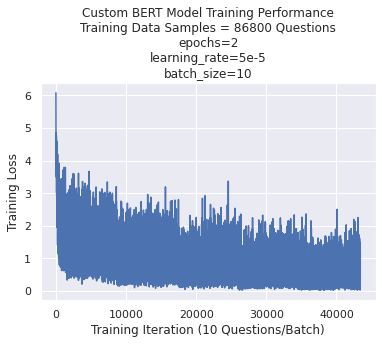

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#create an array for the x-axis of the plot
iterations = np.arange(0,(samples/10)*5,1)

sns.set_theme(font_scale=1)
lossPlot = sns.lineplot(x=iterations, y=training_losses)
lossPlot.set_title("Custom BERT Model Training Performance Histogram\nTraining Data Samples = 86800 Questions\nepochs=2\nlearning_rate=1e-4\nbatch_size=10")
lossPlot.set(xlabel = "Training Iteration (10 Questions/Batch)", ylabel = "Training Loss")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


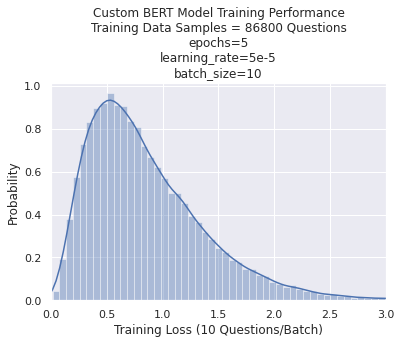

In [ ]:
#histogram plot of loss
from scipy.stats import norm
# losshistPlot = sns.histplot(x=training_losses,bins=100,stat="density")
losshistPlot = sns.distplot(x=training_losses,bins=100,hist=True)
losshistPlot.set_title("Custom BERT Model Training Performance\nTraining Data Samples = 86800 Questions\nepochs=5\nlearning_rate=5e-5\nbatch_size=10")
losshistPlot.set(xlabel = "Training Loss (10 Questions/Batch)")
losshistPlot.set(ylabel = "Probability")
losshistPlot.set_xlim(0, 3)
plt.show()

### Save the BERT model to the desktop

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files

# Save model
model_path = "Custom-BERT-model-2"
# torch.save(model,model_path)
BERT_model_trained.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Custom-BERT-model-2/tokenizer_config.json',
 'Custom-BERT-model-2/special_tokens_map.json',
 'Custom-BERT-model-2/vocab.txt',
 'Custom-BERT-model-2/added_tokens.json',
 'Custom-BERT-model-2/tokenizer.json')

### Evaluate the trained BERT model

In [ ]:
def Test_BERT(model,test_data,batch_size=1):
    model.eval()
    # initialize validation set data loader
    val_loader = DataLoader(test_data, batch_size=batch_size)
    # initialize list to store accuracies
    acc = []
    # loop through batches
    for batch in val_loader:
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            # we will use true positions for accuracy calc
            start_true = batch['start']
            end_true = batch['end']

            # print(start_true)
            # print(end_true)

            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull prediction tensors out and argmax to get predicted tokens
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)

            # print(start_pred)
            # print(end_pred)

            # calculate accuracy for both and append to accuracy list
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
    # calculate average accuracy in total
    acc = sum(acc)/len(acc)
    
    return acc

### Run the BERT test

In [ ]:
Test_BERT(model=BERT_model_trained,test_data=train_tensor_dataset,batch_size=10)